# 작전
* 2930개 row --> 2885개
* NA 처리
* SalePrice만 log 처리
* NA 처리 이후에, df['TotalSF'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF'] 피쳐 생성
* 카테고리 변수 처리

# 작전상 제외
* log 변환
* poly 피쳐 엔지니어링

# Load modules

In [1]:
import math
import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy.stats import norm
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score, cross_val_predict
import os
print(os.listdir("../../../data/house"))

['ames_shallow_fe.pickle', 'ames.pickle', 'ames_shallow_fe_indexers.pickle', 'descriptions.pickle', 'ames.csv', 'description.txt']


# Load data

In [2]:
df = joblib.load("../../../data/house/ames.pickle")
df.sample(3)

p_i_d  area   price  m_s_sub_class m_s_zoning  lot_frontage  \
1008  527183030  1228  189000            120         RL          40.0   
2632  535478070  1045  120000             20         RL          74.0   
2514  533241010  1694  200000             60         FV         114.0   

      lot_area street alley lot_shape  ... screen_porch pool_area pool_q_c  \
1008      4671   Pave   NaN       IR1  ...            0         0      NaN   
2632      7400   Pave   NaN       Reg  ...            0         0      NaN   
2514      8314   Pave  Pave       IR1  ...          110         0      NaN   

      fence misc_feature misc_val mo_sold yr_sold sale_type  sale_condition  
1008    NaN          NaN        0      10    2008       WD           Normal  
2632    NaN          NaN        0       3    2006       WD           Normal  
2514  GdPrv          NaN        0      11    2006       WD           Normal  

[3 rows x 81 columns]

In [3]:
df.shape

(2930, 81)

# 피쳐 엔지니어링

## y값 체크

In [4]:
import warnings
warnings.filterwarnings('ignore')

width=6.0, height=4.0


Text(0.5, 1.0, 'price -> log1p -> expm1')

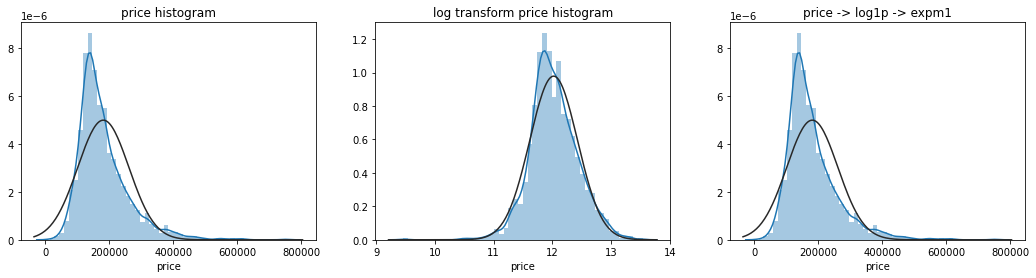

In [5]:
from scipy import stats                                                         

fig, ax = plt.subplots(1,3) # row 1개, column 2개
width, height = fig.get_size_inches()
print('width={w}, height={h}'.format(w=width,h=height))
fig.set_size_inches(width*3, height)

sns.distplot(df['price'], ax=ax[0], fit=norm).set_title('price histogram')
sns.distplot(np.log1p(df['price']), ax=ax[1], fit=norm).set_title('log transform price histogram')
sns.distplot(np.expm1(np.log1p(df['price'])), ax=ax[2], fit=norm).set_title('price -> log1p -> expm1')

# log 변환하면, norm dist에 가까워짐!

### 가장 중요한 SalePrice를 log 변환

In [6]:
df["log_price"] = np.log1p(df["price"])

Text(0.5, 1.0, 'log-transformed price histogram')

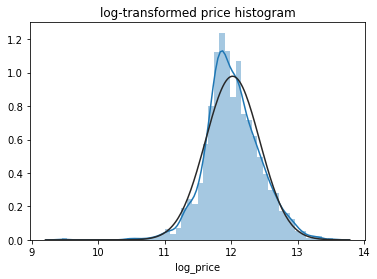

In [7]:
sns.distplot(df['log_price'], fit=norm).set_title('log-transformed price histogram')

# Profiling

## category, numeric feature 들은 무엇이 있나?

In [8]:
# 카테고리변수 필드 처리 --> 숫자 카테고리로 변환
# pd.factorize 를 사용하자... 
# https://www.geeksforgeeks.org/python-pandas-factorize/
from pandas.api.types import is_string_dtype


categorical_feats = [
        f for f in df.columns if (is_string_dtype(df[f]))
]

print('카테고리성 변수는 총 {} 개 이다.'.format(len(categorical_feats)))
print(categorical_feats)

카테고리성 변수는 총 43 개 이다.
['m_s_zoning', 'street', 'alley', 'lot_shape', 'land_contour', 'utilities', 'lot_config', 'land_slope', 'neighborhood', 'condition1', 'condition2', 'bldg_type', 'house_style', 'roof_style', 'roof_matl', 'exterior1st', 'exterior2nd', 'mas_vnr_type', 'exter_qual', 'exter_cond', 'foundation', 'bsmt_qual', 'bsmt_cond', 'bsmt_exposure', 'bsmt_fin_type1', 'bsmt_fin_type2', 'heating', 'heating_q_c', 'central_air', 'electrical', 'kitchen_qual', 'functional', 'fireplace_qu', 'garage_type', 'garage_finish', 'garage_qual', 'garage_cond', 'paved_drive', 'pool_q_c', 'fence', 'misc_feature', 'sale_type', 'sale_condition']


In [9]:
numeric_feats = df.select_dtypes(include=np.number).columns.tolist()

print('숫자형 변수는 총 {} 개 이다.'.format(len(numeric_feats)))
print(numeric_feats)

숫자형 변수는 총 39 개 이다.
['p_i_d', 'area', 'price', 'm_s_sub_class', 'lot_frontage', 'lot_area', 'overall_qual', 'overall_cond', 'year_built', 'year_remod_add', 'mas_vnr_area', 'bsmt_fin_s_f1', 'bsmt_fin_s_f2', 'bsmt_unf_s_f', 'total_bsmt_s_f', 'x1st_flr_s_f', 'x2nd_flr_s_f', 'low_qual_fin_s_f', 'bsmt_full_bath', 'bsmt_half_bath', 'full_bath', 'half_bath', 'bedroom_abv_gr', 'kitchen_abv_gr', 'tot_rms_abv_grd', 'fireplaces', 'garage_yr_blt', 'garage_cars', 'garage_area', 'wood_deck_s_f', 'open_porch_s_f', 'enclosed_porch', 'x3_ssn_porch', 'screen_porch', 'pool_area', 'misc_val', 'mo_sold', 'yr_sold', 'log_price']


In [10]:
df_temp = df.sample(frac=0.1)
df_temp.shape

(293, 82)

## category features profiling

In [11]:
from pandas_profiling import ProfileReport

In [12]:
feats = categorical_feats[0:20]
feats.append('log_price')

profile = ProfileReport(df_temp[feats], 
                        explorative=False,
                        correlations=None,
                        progress_bar=False,
)


#Saving results to a HTML file
profile.to_file("data_profile/profile_categorical_data_0_20.html")

In [13]:
feats = categorical_feats[20:]
feats.append('log_price')

profile = ProfileReport(df_temp[feats], 
                        explorative=False,
                        correlations=None,
                        progress_bar=False,
)


#Saving results to a HTML file
profile.to_file("data_profile/profile_categorical_data_21_42.html")

## numeric features profiling

In [14]:
feats = numeric_feats[0:20]
feats.append('log_price')

profile = ProfileReport(df_temp[feats], 
                        explorative=False,
                        correlations=None,
                        progress_bar=False,
)


#Saving results to a HTML file
profile.to_file("data_profile/profile_numeric_data_0_20.html")

In [15]:
feats = numeric_feats[20:]

# 293개 row, 21개 필드에 1분 걸림
profile = ProfileReport(df_temp[feats], 
                        explorative=False,
                        correlations=None,
                        progress_bar=False,
)


#Saving results to a HTML file
profile.to_file("data_profile/profile_numeric_data_21_38.html")

# data 처리

## Constant (여러 값들로 채워져 있지 않은 필드) 필드 drop 하기

In [11]:
# Utilities는 AllPub이라는 값 외에는 없었으니 없애자
drop_feats = ['street', 'alley', 'utilities', 'pool_q_c']
df.drop(drop_feats, axis=1, inplace=True)

## missing data 처리 필드 찾기

In [12]:
df_na = 100 * df.isnull().sum() / df.shape[0]
display(df_na[1:4])

area             0.0
price            0.0
m_s_sub_class    0.0
dtype: float64

In [13]:
df_na = df_na.drop(df_na[df_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :df_na})
missing_data.head(3) # missing이 80% 이상 데이터는 사용 불가능할듯. LotFrontage 데이터부터는 살려 볼 수 있을까?

Missing Ratio
misc_feature      96.382253
fence             80.477816
fireplace_qu      48.532423

In [14]:
# 필드 중에 대부분은 str이고, lot_frontage, garage_yr_blt 정도만 숫자 필드군..
right = pd.DataFrame(df.dtypes)
left = missing_data
left.join(right,how='left')

Missing Ratio        0
misc_feature        96.382253   object
fence               80.477816   object
fireplace_qu        48.532423   object
lot_frontage        16.723549  float64
garage_cond          5.426621   object
garage_qual          5.426621   object
garage_finish        5.426621   object
garage_yr_blt        5.426621  float64
garage_type          5.358362   object
bsmt_exposure        2.832765   object
bsmt_fin_type2       2.764505   object
bsmt_cond            2.730375   object
bsmt_fin_type1       2.730375   object
bsmt_qual            2.730375   object
mas_vnr_area         0.784983  float64
mas_vnr_type         0.784983   object
bsmt_half_bath       0.068259  float64
bsmt_full_bath       0.068259  float64
total_bsmt_s_f       0.034130  float64
garage_cars          0.034130  float64
garage_area          0.034130  float64
bsmt_unf_s_f         0.034130  float64
bsmt_fin_s_f2        0.034130  float64
bsmt_fin_s_f1        0.034130  float64
electrical           0.034130   object

## NA 변환 함수

In [15]:
def fill_missing(df, cols, val):
    """ Fill with the supplied val """
    for col in cols:
        df[col] = df[col].fillna(val)

def fill_missing_with_mode(df, cols):
    """ Fill with the mode """
    for col in cols:
        df[col] = df[col].fillna(df[col].mode()[0])

## NA를 처리하자

In [16]:
from util import upper_to_underscore

In [17]:
# test
a = ["MSSubClass",'YrSold','MoSold']
b = []
for f in a:
    b.append(upper_to_underscore(f))
b

['m_s_sub_class', 'yr_sold', 'mo_sold']

In [18]:
# NA를 None 값으로 처리 (의미적 처리)
fill_missing(df, ['misc_feature',
                 'fence',
                 'fireplace_qu',
                 'garage_type',
                 'garage_finish',
                 'garage_qual',
                 'garage_cond',
                 'bsmt_qual',
                 'bsmt_cond',
                 'bsmt_exposure',
                 'bsmt_fin_type1',
                 'bsmt_fin_type2',
                 'mas_vnr_type',
                 'm_s_sub_class'], "None")
# NA를 Unknown으로.
fill_missing(df, ['electrical'], 'Unknown')
# NA를 0 으로 처리 (의미적 처리)
fill_missing(df, ['garage_yr_blt',
                 'garage_area',
                 'garage_cars',
                 'bsmt_fin_s_f1',
                 'bsmt_fin_s_f2',
                 'bsmt_unf_s_f',
                 'total_bsmt_s_f',
                 'bsmt_full_bath',
                 'bsmt_half_bath',
                 'mas_vnr_area'], 0)
fill_missing_with_mode(df, ['m_s_zoning', 'kitchen_qual', 'exterior1st', 'exterior2nd', 'sale_type'])
fill_missing(df, ["functional"],"Typ")

## garage_yr_blt
* 년도가 아닌 0의 값이 있는 row들이 많다
* 0을 YearBuilt와 같은 값으로 채운다
* df.loc[<mask>(here mask is generating the labels to index) , <optional column(s)> ]
* df.loc[df['First Season'] > 1990, 'First Season'] = 1
* e.g. df['First Season'] = np.where(df['First Season'] > 1990, 1, df['First Season'])

In [20]:
df.loc[df['garage_yr_blt']==0,'garage_yr_blt'] = df['year_remod_add']

In [27]:
df['garage_yr_blt'] = df['garage_yr_blt'].astype(int)

In [21]:
# garage_yr_blt 가 2207 년으로 들어가 있는 row 가 있는 것을 발견
df[['garage_yr_blt','yr_sold','year_built','year_remod_add']].describe()

garage_yr_blt      yr_sold   year_built  year_remod_add
count    2930.000000  2930.000000  2930.000000     2930.000000
mean     1977.934812  2007.790444  1971.356314     1984.266553
std        25.383804     1.316613    30.245361       20.860286
min      1895.000000  2006.000000  1872.000000     1950.000000
25%      1960.000000  2007.000000  1954.000000     1965.000000
50%      1979.000000  2008.000000  1973.000000     1993.000000
75%      2002.000000  2009.000000  2001.000000     2004.000000
max      2207.000000  2010.000000  2010.000000     2010.000000

In [22]:
df[df['garage_yr_blt']>2010]

p_i_d  area   price  m_s_sub_class m_s_zoning  lot_frontage  \
2260  916384070  1564  267300             20         RL          68.0   

      lot_area lot_shape land_contour lot_config  ... screen_porch pool_area  \
2260      8298       IR1          HLS     Inside  ...            0         0   

     fence misc_feature misc_val mo_sold  yr_sold  sale_type  sale_condition  \
2260  None         None        0       9     2007        New         Partial   

      log_price  
2260  12.496131  

[1 rows x 78 columns]

In [23]:
df.loc[df['garage_yr_blt']>2010,'garage_yr_blt'] = df['year_remod_add']

In [26]:
# 재검사! --> 문제 제거됨!
df[['garage_yr_blt','yr_sold','year_built','year_remod_add']].describe()

garage_yr_blt      yr_sold   year_built  year_remod_add
count    2930.000000  2930.000000  2930.000000     2930.000000
mean     1977.866553  2007.790444  1971.356314     1984.266553
std        25.034117     1.316613    30.245361       20.860286
min      1895.000000  2006.000000  1872.000000     1950.000000
25%      1960.000000  2007.000000  1954.000000     1965.000000
50%      1979.000000  2008.000000  1973.000000     1993.000000
75%      2002.000000  2009.000000  2001.000000     2004.000000
max      2010.000000  2010.000000  2010.000000     2010.000000

In [28]:
df[['garage_yr_blt','year_built']].head(5)

garage_yr_blt  year_built
0           1960        1960
1           1961        1961
2           1958        1958
3           1968        1968
4           1997        1997

## year_remod_add

In [29]:
df.loc[df['year_remod_add']==1950,'year_remod_add'] = df['year_built']
df['year_remod_add'] = df['year_remod_add'].astype(int)

In [30]:
df_na = 100 * df.isnull().sum() / df.shape[0]

In [31]:
df_na = df_na.drop(df_na[df_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :df_na})
missing_data # LotFrontage 데이터 이후부터는 사용 불가일 듯...

Missing Ratio
lot_frontage      16.723549

### lot_frontage의 missing ratio가 17%이긴 하지만, 좀 살려보자 (why? price와는 corr가 괜찮음)

In [32]:
# LotFrontage는 대략 21%가 NA였는데, 가장 비슷한 값을 넣어주려고, 이웃들의 LotFrontage의 가장 많은 값(median)을 넣어주자
df["lot_frontage"] = df.groupby("neighborhood")["lot_frontage"].transform(
                                            lambda x: x.fillna(x.median()))

### OverallQual 가 높아야 SalePrice 가 높아지는데, 
* OverallQual가 낮아도 SalePrice가 높은 row들은 제거하자
* <필드 없음.. 코드 생략> GrLivArea가 높은데도, SalePrice가 낮은 row들도 제거하자
* lot_frontage, lot_area 의 outlier를 제거하자

In [33]:
df.drop(df[(df['overall_qual']<5) & (df['price']>200000)].index, inplace=True)
df.drop(df[(df['lot_frontage']>200)].index, inplace=True)
df.drop(df[(df['lot_area']>30000)].index, inplace=True)
df.drop(df[(df['enclosed_porch'])>400].index, inplace=True)
df.reset_index(drop=True, inplace=True)

In [34]:
# 2930 --> 2928 (2개 row가 삭제)
df.shape

(2888, 78)

### 숫자 필드 중에, 카테고리성 필드가 있어서,
* 이들 필드는 카테고리로 형태 변환하자

In [35]:
df['m_s_sub_class'] = df['m_s_sub_class'].apply(str)
df['yr_sold'] = df['yr_sold'].astype(str)
df['mo_sold'] = df['mo_sold'].astype(str)

### NA 다시 체크
* NA 더이상 없음을 확인

In [36]:
df_na = 100 * df.isnull().sum() / len(df)
df_na = df_na.drop(df_na[df_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :df_na})
display(missing_data) # LotFrontage 데이터 이후부터는 사용 불가일 듯...
# 0.1% lot_frontage는 살리기 힘들겠군.. --> 3개 row --> drop 하자..
display(df[df['lot_frontage'].isna()])
df = df.dropna()
print('finally... df gets clean')
display(df.shape)

Missing Ratio
lot_frontage       0.103878

p_i_d  area   price m_s_sub_class m_s_zoning  lot_frontage  \
2229  916253320  1502  330000           120         RM           NaN   
2749  907230240  1320  137000           160         RH           NaN   
2852  916252170  1295  230000           120         RM           NaN   

      lot_area lot_shape land_contour lot_config  ... screen_porch pool_area  \
2229      9763       IR1          Lvl     Inside  ...            0         0   
2749      3612       IR1          Lvl     Inside  ...            0         0   
2852      8239       IR1          Lvl     Inside  ...            0         0   

      fence misc_feature misc_val mo_sold  yr_sold  sale_type  sale_condition  \
2229   None         None        0       9     2007        WD           Normal   
2749  MnPrv         None        0       6     2006        WD           Normal   
2852   None         None        0      11     2006        WD           Normal   

      log_price  
2229  12.706851  
2749  11.827744  
2852  12.345839  

[3 rows x 78 columns]

finally... df gets clean


(2885, 78)

## 카테고리성 변수들의 처리

### pd.factorize를 이용한 encode

In [37]:
#categorical_feats - drop_feats
encoded_feats = [x for x in categorical_feats if x not in drop_feats]

In [38]:
indexers = {} # map
for f_ in encoded_feats:
    df[f_], indexer = pd.factorize(df[f_])
    indexers[f_] = indexer

In [39]:
indexers

{'m_s_zoning': Index(['RH', 'RL', 'FV', 'RM', 'C (all)', 'I (all)', 'A (agr)'], dtype='object'),
 'lot_shape': Index(['Reg', 'IR1', 'IR2', 'IR3'], dtype='object'),
 'land_contour': Index(['Lvl', 'HLS', 'Bnk', 'Low'], dtype='object'),
 'lot_config': Index(['Inside', 'Corner', 'CulDSac', 'FR2', 'FR3'], dtype='object'),
 'land_slope': Index(['Gtl', 'Mod', 'Sev'], dtype='object'),
 'neighborhood': Index(['NAmes', 'Gilbert', 'StoneBr', 'NWAmes', 'Somerst', 'BrDale', 'NPkVill',
        'NridgHt', 'Blmngtn', 'NoRidge', 'SawyerW', 'Sawyer', 'Greens',
        'BrkSide', 'OldTown', 'IDOTRR', 'ClearCr', 'SWISU', 'Edwards',
        'CollgCr', 'Crawfor', 'Blueste', 'Mitchel', 'Timber', 'MeadowV',
        'Veenker'],
       dtype='object'),
 'condition1': Index(['Feedr', 'Norm', 'PosN', 'RRNe', 'RRAe', 'Artery', 'PosA', 'RRAn',
        'RRNn'],
       dtype='object'),
 'condition2': Index(['Norm', 'Feedr', 'PosA', 'PosN', 'Artery', 'RRNn', 'RRAe', 'RRAn'], dtype='object'),
 'bldg_type': Index(['1Fam

In [40]:
df[encoded_feats].tail(5)

m_s_zoning  lot_shape  land_contour  lot_config  land_slope  \
2883           1          1             0           2           0   
2884           1          1             3           0           1   
2885           1          0             0           0           0   
2886           1          0             0           0           1   
2887           1          0             0           0           1   

      neighborhood  condition1  condition2  bldg_type  house_style  ...  \
2883            22           1           0          0            4  ...   
2884            22           1           0          0            0  ...   
2885            22           1           0          0            3  ...   
2886            22           1           0          0            0  ...   
2887            22           1           0          0            1  ...   

      fireplace_qu  garage_type  garage_finish  garage_qual  garage_cond  \
2883             0            2              0            0            0   
2884             0            0              0            0            0   
2885             0            3              3            1            1   
2886             1            0              2            0            0   
2887             1            0              1            0            0   

      paved_drive  fence  misc_feature  sale_type  sale_condition  
2883            0      2             0          0               0  
2884            0      0             0          0               0  
2885            0      0             2          0               0  
2886            0      1             0          0               0  
2887            0      1             0          0               0  

[5 rows x 39 columns]

## 신규 필드 생성

In [41]:
df['total_s_f'] = df['total_bsmt_s_f'] + df['x1st_flr_s_f'] + df['x2nd_flr_s_f']

# Feature Engineering 이후의 데이터 프로파일링 해보기

In [40]:
df_temp = df.sample(frac=0.1)

In [41]:
feats = df.columns.values.tolist()
feats.remove('price')
feats.remove('log_price')
len(feats)

feats = feats[0:25]
feats.append('price')
feats.append('log_price')

profile = ProfileReport(df_temp[feats], 
                        explorative=False,
                        correlations=None,
                        progress_bar=False,
)


#Saving results to a HTML file
profile.to_file("data_profile/profile_shallow_fe_data_0_25.html")

In [42]:
feats = df.columns.values.tolist()
feats.remove('price')
feats.remove('log_price')
len(feats)

feats = feats[25:50]
feats.append('price')
feats.append('log_price')

profile = ProfileReport(df_temp[feats], 
                        explorative=False,
                        correlations=None,
                        progress_bar=False,
)


#Saving results to a HTML file
profile.to_file("data_profile/profile_shallow_fe_data_25_50.html")

In [43]:
feats = df.columns.values.tolist()
feats.remove('price')
feats.remove('log_price')
len(feats)

feats = feats[50:]
feats.append('price')
feats.append('log_price')

profile = ProfileReport(df_temp[feats], 
                        explorative=False,
                        correlations=None,
                        progress_bar=False,
)


#Saving results to a HTML file
profile.to_file("data_profile/profile_shallow_fe_data_50_end.html")

# Save DF

In [42]:
import joblib

In [43]:
filename = '../../../data/house/ames_shallow_fe.pickle'
joblib.dump(df, filename)

['../../../data/house/ames_shallow_fe.pickle']

In [46]:
filename = '../../../data/house/ames_shallow_fe_indexers.pickle'
joblib.dump(indexers, filename)

['../../../data/house/ames_shallow_fe_indexers.pickle']